In [1]:
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.loaders import BaseShockSlowInteractionsLoader
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.io import load_neurons, load_derived_generic
import seaborn as sns
import pandas as pd
import numpy as np
from drn_interactions.interactions.graph_clustering import SpectralCluster, ClusterRunner, ClusterEvaluation, ClusterResults
import warnings
from drn_interactions.config import Config, ExperimentInfo
from tqdm import tqdm

dd = Config.derived_data_dir / "ensembles"
dd.mkdir(exist_ok=True)
sns.set_theme(style="ticks", context="paper")

In [5]:
def load_responders():
    slow_responders_shock = load_derived_generic(
        "slow_ts_foot_shock_unit_responders_pre_to_shock.csv"
    )[["neuron_id", "diff_inv", "sig"]].assign(
        response_fs_slow=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["diff_inv"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_fs_slow"]]

    fast_responders = load_derived_generic("fast_fs_foot_shock_unit_responders.csv")[
        ["neuron_id", "Diff", "sig"]
    ].assign(
        response_fs_fast=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["Diff"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_fs_fast"]]
    df_responders = pd.merge(slow_responders_shock, fast_responders, on="neuron_id", how="outer")
    return df_responders
    

In [3]:
sessions = ExperimentInfo.foot_shock_sessions_10min

preprocessor = InteractionsPreprocessor(z=True, minmax=False)
evaluator = ClusterEvaluation()

loader_fac = lambda session, block, bin_width: BaseShockSlowInteractionsLoader(
    session_name=session, block=block, bin_width=bin_width,
)
corr_fac = lambda: PairwiseCorr(
    remove_self_interactions=True,
    rectify=True,
    shuffle=False,
    remove_duplicate_combs=True,
)
cluster_fac = lambda: SpectralCluster(
    n_clusters=np.arange(2, 8), spectral_kws={"affinity": "precomputed"}, n_init=3
)

runner_fac = lambda session, block, bin_width: ClusterRunner(
    loader=loader_fac(session=session, block=block, bin_width=bin_width),
    preprocessor=preprocessor,
    affinity_calculator=corr_fac(),
    clusterer=cluster_fac(),
    evalulator=evaluator,
)

In [4]:
ensemble_frames = []
ensemble_stats_frames = []

for bin_width in (0.05, 0.1, 0.5, 1):
    for block in ("pre", "base_shock"):
        for session in tqdm(sessions):

            # calculate ensembles
            runner = runner_fac(session=session, block=block, bin_width=bin_width)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    _, ensembles, _, ensemble_stats = runner.run(10)
                except ValueError as e:
                    print(e)
                    print(session)
                    continue

            # add metadata and append to list of results
            ensembles = ensembles.assign(session_name=session, block=block, bin_width=bin_width)
            ensemble_stats = ensemble_stats.assign(session_name=session, block=block, bin_width=bin_width)
            ensemble_stats_frames.append(ensemble_stats)
            ensemble_frames.append(ensembles)

df_ensembles = pd.concat(ensemble_frames).reset_index(drop=True)
df_ensembles_stats = pd.concat(ensemble_stats_frames).reset_index(drop=True)

df_ensembles_stats["ensemble_id"] = pd.factorize(
    df_ensembles_stats["ensemble"].astype(str)
    + df_ensembles_stats["session_name"]
    + df_ensembles_stats["block"]
    + df_ensembles_stats["bin_width"].astype(str)
)[0]
df_ensembles_stats["ensemble_id"] = np.where(
    df_ensembles_stats["ensemble"] == -1,
    -1,
    df_ensembles_stats["ensemble_id"],
)
df_ensembles = (
    df_ensembles.merge(
    df_ensembles_stats[["session_name", "ensemble", "ensemble_id", "block", "bin_width"]],
    on=["session_name", "ensemble", "block", "bin_width"]
    )
)

df_ensembles.to_csv(dd / "fs - ensembles.csv", index=False)
df_ensembles_stats.to_csv(dd / "fs - stats.csv", index=False)


100%|██████████| 8/8 [01:05<00:00,  8.18s/it]


### Descrip 1s Ensembles

In [6]:
# make true df_ensemble and df_ensembles_stats and global ensemble ID

df_ensembles = pd.read_csv(dd / "fs - ensembles.csv", ).drop_duplicates().loc[lambda x: x.bin_width == 1]
df_ensembles_stats= pd.read_csv(dd / "fs - stats.csv").drop_duplicates().loc[lambda x: x.bin_width == 1]
neuron_types = load_derived_generic("neuron_types.csv")
df_responders = load_responders()

descriptor = ClusterResults(neuron_types=neuron_types)
stats2 = descriptor.ensemble_results(df_ensembles, df_ensembles_stats)
response_entropy = descriptor.ensemble_response_entropy(
    df_ensembles, 
    df_response=df_responders,
    df_response_response_col="response_fs_slow",
    created_col = "response_fs_entropy"
)
stats2 = stats2.merge(response_entropy)


df_ensembles.to_csv(dd / "fs - ensembles - true.csv", index=False)
stats2.to_csv(dd / "fs - stats - true.csv", index=False)

### Ensemble Properties

Are the properties of ensembles different between the two states?

Properties:
- Size
- Average Weight
- Average Conductivity
- Edge Expantion

In [7]:
from drn_interactions.stats import mannwhitneyu_plusplus
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK

In [8]:
df_stats = (
    load_derived_generic("ensembles/fs - stats - true.csv")
    .query("bin_width == 1")
)

df_ensembles = (
    load_derived_generic("ensembles/fs - ensembles - true.csv")
    .query("bin_width == 1")
)
neuron_types = load_derived_generic("neuron_types.csv")
df_response =  load_derived_generic("graph/fs - responders.csv")


In [8]:
descriptor = ClusterResults(
    neuron_types=neuron_types,
)
stats = descriptor.ensemble_results(df_ensembles, df_stats)

slow_entropy = descriptor.ensemble_response_entropy(
    ensemble_res=df_ensembles, 
    df_response=df_response, 
    created_col = "slow_response_entropy",
    df_response_response_col="response_fs_slow"
)

fast_entropy = descriptor.ensemble_response_entropy(
    ensemble_res=df_ensembles, 
    df_response=df_response, 
    created_col = "fast_response_entropy",
    df_response_response_col="response_fs_fast"
)

stats = stats.merge(slow_entropy).merge(fast_entropy)
stats.to_csv(dd / "fs - descripted.csv", index=False)


size
 n_pre          15.00
n_shock        14.00
Mean_pre       12.80
Mean_shock      9.36
Diff           -3.44
U             113.00
p               0.74
dtype: float64

average_weight
 n_pre          15.00
n_shock        14.00
Mean_pre        0.25
Mean_shock      0.26
Diff            0.01
U             105.00
p               1.00
dtype: float64

average_weight_out
 n_pre          15.00
n_shock        14.00
Mean_pre        0.09
Mean_shock      0.08
Diff           -0.01
U             133.00
p               0.23
dtype: float64

neuron_type_entropy
 n_pre          15.00
n_shock        14.00
Mean_pre        1.00
Mean_shock      1.02
Diff            0.02
U             101.00
p               0.88
dtype: float64

response_fs_entropy
 n_pre          15.00
n_shock        14.00
Mean_pre        0.82
Mean_shock      0.65
Diff           -0.16
U             126.00
p               0.37
dtype: float64

in_out_ratio
 n_pre         15.00
n_shock       14.00
Mean_pre       3.01
Mean_shock     3.29
Diff  

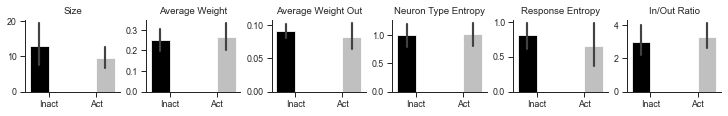

In [24]:
from drn_interactions.stats import mannwhitneyu_plusplus
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK

def compare_metric(df, metric):
    x = df.query("ensemble_id != -1 and block == 'pre'")[metric].values
    y = df.query("ensemble_id != -1 and block == 'base_shock'")[metric].values
    try:
        return mannwhitneyu_plusplus(x, y, names=("pre", "shock")).round(2)
    except ValueError:
        return np.nan

def plot_metric(df, metric, ax, **kwargs):
    return (
        df
        .query("ensemble_id != -1")
        .pipe((sns.barplot, "data"), x="block", y=metric, order=("pre", "base_shock"), hue="block", ax=ax, **kwargs)
    )


df_stats = pd.read_csv(dd / "fs - stats - true.csv").assign(in_out_ratio=lambda x: x.average_weight / x.average_weight_out)

f = plt.figure(figsize=(10, 1.5), constrained_layout=True)
axes = f.subplots(1, 6, sharex=True)

for i, (metric, lab) in enumerate(zip(
    ("size", "average_weight", "average_weight_out", "neuron_type_entropy", "response_fs_entropy", "in_out_ratio"), 
    ("Size", "Average Weight", "Average Weight Out", "Neuron Type Entropy", "Response Entropy", "In/Out Ratio")
    )):
    res = compare_metric(df_stats, metric)
    print(f"\n{metric}\n", res)
    ax = axes[i]
    plot_metric(df_stats, metric, ax, palette=PAL_GREY_BLACK)
    ax.legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(lab)
    ax.set_xticklabels(["Inact", "Act"])

sns.despine(fig=f)


In [25]:
from drn_interactions.stats import se_prop
from scipy.stats import chi2_contingency

df_stats = pd.read_csv(dd / "fs - ensembles - true.csv")


df_ensembles["in_ensemble"] = np.where(
    df_ensembles["ensemble"] != -1, 1, 0
    )

prop = df_ensembles["in_ensemble"].mean() * 100
se = se_prop(df_ensembles["in_ensemble"]) * 200

print(f"Proportion of units in an ensemble {prop:.2f}% +- {se:.2f}")

X = pd.crosstab(
    df_ensembles["in_ensemble"], df_ensembles["block"]
    )

stat, p, _, _ = chi2_contingency(X)

print(f"stat = {stat:.2f}.\np = {p:.2f}")

display(X)

Xt = pd.crosstab(
    df_ensembles["in_ensemble"], df_ensembles["block"], normalize="index"
    )
display(Xt.multiply(100).round(2))

Proportion of units in an ensemble 62.48% +- 4.26
stat = 30.32.
p = 0.00


block,base_shock,pre
in_ensemble,,
0,128,66
1,131,192


block,base_shock,pre
in_ensemble,,
0,65.98,34.02
1,40.56,59.44
